In [1]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Your text input
text = ["This is a tokenization test", "This is a tokenization test"]

# Tokenize the text and add special tokens
encoded_input = tokenizer.encode_plus(text, add_special_tokens=True)
tokens = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

# Print the tokens
print("Tokens: ", tokens)

c:\Users\oskar\NTNU\9. semester\TDT13\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Tokens:  ['[CLS]', 'this', 'is', 'a', 'token', '##ization', 'test', '[SEP]', 'this', 'is', 'a', 'token', '##ization', 'test', '[SEP]']


In [5]:
from pyproj import Proj, Transformer

def lv95_converter(lat, lon, inverse=False):
    wgs84 = 'epsg:4326'  
    lv95 = 'epsg:2056'  

    if inverse: 
        transformer = Transformer.from_crs(lv95, wgs84)
    else:
        transformer = Transformer.from_crs(wgs84, lv95)

    easting, northing = transformer.transform(lat, lon)
    return easting, northing

bern_lv95 = lv95_converter(2600667.4752589185, 1199657.3163924862, inverse=True)
print("LV95 Coordinates of Bern:", bern_lv95)

LV95 Coordinates of Bern: (46.94800001030181, 7.4474000073948154)


In [35]:
from pyproj import Transformer
import numpy as np
import pandas as pd
import utm

vardial_path = '../vardial-shared-tasks/SMG2020'

train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])

def lv95_converter(lat, lon, inverse=False):
    wgs84 = 'epsg:4326'  
    lv95 = 'epsg:2056'  

    if inverse: 
        transformer = Transformer.from_crs(lv95, wgs84)
    else:
        transformer = Transformer.from_crs(wgs84, lv95)

    easting, northing = transformer.transform(lat, lon)
    return easting, northing

def to_projection(df, config): 
    default_col_names = ['lat', 'lon', 'text']
    new_col_names = None
    if 'projection' in config: 
        match config['projection']: 
            case 'utm': 
                new_col_names = ['easting', 'northing', 'text']
                
                df[['lat', 'lon']] = df.apply(
                    lambda row: utm.from_latlon(
                        row['lat'], row['lon'], 
                        force_zone_number=32, 
                        force_zone_letter='T')[:2], 
                    axis=1, result_type='expand')
                df.columns = new_col_names
            
            case 'lv95':
                new_col_names = ['easting', 'northing', 'text']

                df[['lat', 'lon']] = df.apply(
                    lambda row: lv95_converter(row['lat'], row['lon']),
                    axis=1, result_type='expand')
                df.columns = new_col_names

    return df, new_col_names if new_col_names else default_col_names

def transform_to_latlon(latlon, config): 
    latlon_trans = None
    
    if 'projection' not in config: 
        return latlon
    
    match config['projection']: 
        case 'utm': 
            latlon_trans = np.array(utm.to_latlon(
                 latlon[:, 0], latlon[:, 1], zone_number=32, zone_letter='T')).T
            
            return latlon_trans
        
        case 'lv95': 
            latlon_trans = np.array(lv95_converter(
                 latlon[:, 0], latlon[:, 1], inverse=True)).T
            
            return latlon_trans

        case _: 
            return latlon
        
train_data = train_data.head()

config = { 'projection': 'utm' }

train_data, col_names = to_projection(train_data, config)
train_data = transform_to_latlon(train_data[col_names[:2]].to_numpy(), config)
train_data

array([[47.22,  7.43],
       [46.86,  8.21],
       [47.39,  8.18],
       [47.37,  8.78],
       [47.39,  8.04]])

In [2]:
import numpy as np

def haversine_distance(c1, c2):
    """c1 and c2 are arrays containing lat/lon in degrees"""
    R = 6371  # Radius of Earth [km]

    c1 = np.radians(c1)
    c2 = np.radians(c2)
    dlat = c2[:, 0] - c1[:, 0]
    dlon = c2[:, 1] - c1[:, 1]

    a = np.sin(dlat / 2)**2 + np.cos(c1[:, 0]) * \
        np.cos(c2[:, 0]) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distance [km]


def haversine_distance2(c1, c2):
    R = 6371 

    c1 = np.radians(c1)
    c2 = np.radians(c2)
    dlat = c2[:, 0] - c1[:, 0]
    dlon = c2[:, 1] - c1[:, 1]

    a = np.sin(dlat / 2)**2 + np.cos(c1[:, 0]) * \
        np.cos(c2[:, 0]) * np.sin(dlon / 2)**2
    d = 2 * R * np.arcsin(np.sqrt(a))

    return d



# Coordinates for New York City and Sydney (c1)
coords_c1 = np.array([
    [40.7128, -74.0060],  # New York City
    [-33.8688, 151.2093]  # Sydney
])

# Coordinates for Paris, Cape Town, and Tokyo (c2)
coords_c2 = np.array([
    [48.8566, 2.3522],   # Paris
    [-33.9249, 18.4241],  # Cape Town
])


np.median(haversine_distance(coords_c1, coords_c2)), np.median(haversine_distance2(coords_c1, coords_c2))

(8424.452517551614, 8424.452517551614)

In [3]:
import pandas as pd

train = pd.read_table('../vardial-shared-tasks/SMG2020/ch/train.txt', names=['lat', 'lon', 'text'])
dev = pd.read_table('../vardial-shared-tasks/SMG2020/ch/test_gold.txt', names=['lat', 'lon', 'text'])
test = pd.read_table('../vardial-shared-tasks/SMG2020/ch/dev.txt', names=['lat', 'lon', 'text'])

# train['text'] = train['text'].apply(lambda t: f'{t[:80]}...')
# df_latex = train.head().to_latex()

# print(df_latex.replace('\\n', '\n'))
train.head()

,lat,lon,text
0,47.22,7.43,Dr Chester Bennington isch tot 😔😔😔 #rip #linki...
1,46.86,8.21,Mini Fründin hed Lust uf Doktorspieli gha... ....
2,47.39,8.18,Slayer isch besser. Det han ich gescht mini Dr...
3,47.37,8.78,gaht au innere stund? bin grad am speck brate ...
4,47.39,8.04,sie: thy er: ? sie: thy= thank you er: player ...


In [4]:
print(f'Train size: {len(train)}')
print(f'Dev size: {len(dev)}')
print(f'Test size: {len(test)}')

Train size: 22600
Dev size: 3097
Test size: 3068


In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Example data
data = {
    'lat': train['lat'],
    'lon': train['lon'],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# # Save as Shapefile
# geo_df.to_file("locations.shp")

# # Save as GeoJSON
# geo_df.to_file("locations.geojson", driver='GeoJSON')

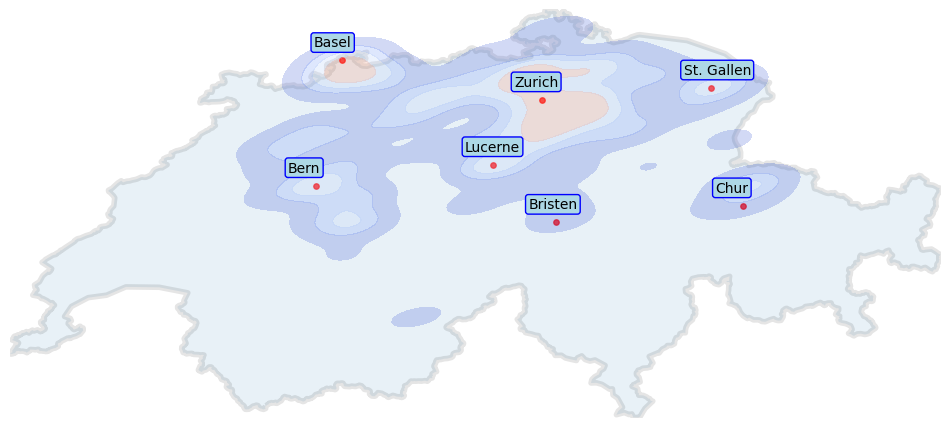

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd

fig, ax = plt.subplots(figsize=(12, 8))

switzerland_polygon = gpd.read_file('../data/switzerland.geojson')
switzerland_polygon.plot(ax=ax, alpha=0.1, edgecolor='k', linewidth=4)

bounds = switzerland_polygon.bounds
plt.xlim(bounds['minx'].min(), bounds['maxx'].max())
plt.ylim(bounds['miny'].min(), bounds['maxy'].max())

city_gdf = gpd.read_file('../data/swiss_cities.csv', index=False)
city_gdf['geometry'] = [Point(lon, lat)
                        for lon, lat in zip(city_gdf['lon'], city_gdf['lat'])]

city_gdf.plot(ax=ax, markersize=15, color='red',
              alpha=0.8, marker='o', label='Cities')
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf['city']):
    ax.annotate(label, xy=(x, y), xytext=(-20, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', edgecolor='blue', facecolor='lightblue'))

# Create the heatmap
sns.kdeplot(data=df,
            x='lon',
            y='lat',
            fill=True,
            cmap='coolwarm',
            alpha=0.25,
            gridsize=200,
            levels=5,
            ax=ax)


ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()